In [2]:
import pandas as pd
import numpy as np
import os
import pickle
import scipy.stats as st
import scipy.signal as sg
import matplotlib.pyplot as plt
import matplotlib as mpl
import npc_lims
from npc_sessions import DynamicRoutingSession
from dynamic_routing_analysis import spike_utils

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

%load_ext autoreload
%autoreload 2


In [ ]:
loadpath=r'\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\decoding results\timebins'

svc_results={}
decoder_results=os.listdir(loadpath)

for ii,ff in enumerate(decoder_results[15:16]):
    with open(os.path.join(loadpath,ff),'rb') as handle:
        svc_results[ii]=pickle.load(handle)
    print(ff)

644867_2023-02-23_0_decode_timebins.pkl


In [2]:
loadpath=r'\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\decoding results\timebins'
svc_results={}
decoder_results=os.listdir(loadpath)

In [3]:
# decoder_results[:]
# svc_results.keys()
performance=pd.read_parquet(
            npc_lims.get_cache_path('performance','666986_2023-08-17',version='0.0.214')
        )
performance

,start_time,stop_time,block_index,number_of_rewards,rewarded_modality,cross_modal_dprime,signed_cross_modal_dprime,same_modal_dprime,nonrewarded_modal_dprime,vis_intra_dprime,aud_intra_dprime,session_idx,date,subject_id,session_id
id,,,,,,,,,,,,,,,
0,2510.48356,3116.04130,0,21,vis,0.317221,0.317221,1.475261,1.491822,1.475261,1.491822,0,2023-08-17,666986,666986_2023-08-17_0
1,3116.59181,3724.05085,1,24,aud,2.742528,-2.742528,3.158572,1.155368,1.155368,3.158572,0,2023-08-17,666986,666986_2023-08-17_0
2,3724.46789,4331.59348,2,24,vis,2.941079,2.941079,3.582785,0.956816,3.582785,0.956816,0,2023-08-17,666986,666986_2023-08-17_0
3,4333.34503,4936.58398,3,23,aud,2.438906,-2.438906,2.588996,1.120453,1.120453,2.588996,0,2023-08-17,666986,666986_2023-08-17_0
4,4939.80325,5543.82625,4,23,vis,1.774796,1.774796,3.829012,2.054216,3.829012,2.054216,0,2023-08-17,666986,666986_2023-08-17_0
5,5544.22651,6147.86579,5,25,aud,2.996397,-2.996397,3.628355,0.608420,0.608420,3.628355,0,2023-08-17,666986,666986_2023-08-17_0


In [8]:
switch_aligned_decoding={
    'session_id':[],
    'switch_index':[],
    'structure':[],
    'n_units':[],
    'before_dprime':[],
    'after_dprime':[],
    'decision_function_20':[],
    'decision_function_all':[],
}

#load session
for ii,ff in enumerate(decoder_results[:]):
    with open(os.path.join(loadpath,ff),'rb') as handle:
        svc_results=pickle.load(handle)
    print(ff)

    all_areas=np.unique(list(svc_results['block_ids'].keys()))
    timepoints=[0]
    label_list=['vis','aud']
    predict=['block_ids']
    n_units=svc_results['unit_numbers']
    unit_numbers=np.arange(0,len(n_units))
    n_repeats=svc_results['n_repeats']

    #extract decision functions
    
    timebin=0
    predict=['block_ids']
    dec_func={}
    dec_func_shuffle={}

    for p in predict:
        dec_func[p]={}
        dec_func_shuffle[p]={}
        for n_units in unit_numbers:
            dec_func[p][n_units]={}
            dec_func_shuffle[p][n_units]={}
            for aa in all_areas:
                if aa in svc_results[p].keys():
                    dec_func[p][n_units][aa]={}
                    dec_func_shuffle[p][n_units][aa]={}
                    if len(svc_results[p][aa][timebin][n_units])>0:
                        dec_func_all=[]
                        dec_func_shuffle_all=[]
                        for repeat in range(0,n_repeats):
                            dec_func[p][n_units][aa][repeat]=svc_results[p][aa][timebin][n_units][repeat]['decision_function']
                            dec_func_shuffle[p][n_units][aa][repeat]=svc_results[p][aa][timebin][n_units][repeat]['shuffle']['decision_function']
                            dec_func_all.append(dec_func[p][n_units][aa][repeat])
                            dec_func_shuffle_all.append(dec_func_shuffle[p][n_units][aa][repeat])
                        
                        dec_func[p][n_units][aa]['average']=np.nanmean(np.vstack(dec_func_all),axis=0)
                        dec_func_shuffle[p][n_units][aa]['average']=np.nanmean(np.vstack(dec_func_shuffle_all),axis=0)

    #align results to switch times
    all_areas=np.unique(np.hstack(all_areas))
    unit_numbers=np.arange(0,len(svc_results['unit_numbers']))

    decoder_conf_context_switch={}
    # loop through areas
    for aa in all_areas:
        decoder_conf_context_switch[aa]={}
        # loop through n units
        for n_units in unit_numbers:
            decoder_conf_context_switch[aa][n_units]=[]

    session_id=svc_results['metadata'].session_id
    print(session_id)
    #load session table
    session=DynamicRoutingSession(session_id)
    # trials=session.trials[:]
    trials=pd.read_parquet(
                npc_lims.get_cache_path('trials',session.id)
            )
    performance=pd.read_parquet(
                npc_lims.get_cache_path('performance',session.id)
            )

    bin_size=0.1
    timebins_table,bins=spike_utils.make_timebins_table(trials, bin_size)

    context_switch_index=timebins_table.query('is_context_switch').index.values

    # switch_aligned_decoding={}

    # # loop through areas
    # for aa in all_areas:
    #     switch_aligned_decoding[aa]={}

    #     # loop through n units
    #     for n_units in unit_numbers:
    #         switch_aligned_decoding[aa][n_units]=[]

    #get pre/post switch dprime
    context_switch_trials=trials.query('is_context_switch')
    cross_modal_dprime=performance[:]['cross_modal_dprime'].values

    bins_before=300
    bins_after=900
    p='block_ids'

    for aa in all_areas:
        for tt,rc in enumerate(context_switch_index):

            if timebins_table['is_vis_context'].iloc[rc]:
                multiplier=-1
            elif timebins_table['is_aud_context'].iloc[rc]:
                multiplier=1

            switch_aligned_decoding['session_id'].append(session.id)
            switch_aligned_decoding['structure'].append(aa)
            switch_aligned_decoding['n_units'].append(svc_results['block_ids'][aa]['n_units'])
            switch_aligned_decoding['before_dprime'].append(cross_modal_dprime[tt])
            switch_aligned_decoding['after_dprime'].append(cross_modal_dprime[tt+1])
            switch_aligned_decoding['switch_index'].append(tt)

            for n_units in unit_numbers:
                temp_bin_decoding=(dec_func['block_ids'][n_units][aa]['average'][rc-bins_before:rc+bins_after]
                            /np.nanstd(dec_func['block_ids'][n_units][aa]['average'][rc-bins_before:rc+bins_after]))*multiplier
                dec_func_str='decision_function_'+str(svc_results['unit_numbers'][n_units])
                switch_aligned_decoding[dec_func_str].append(temp_bin_decoding)

    # switch_aligned_decoding[aa][n_units]=np.vstack(switch_aligned_decoding[aa][n_units])


# #save to a dictionary/dataframe
# switch_aligned_decoding=pd.DataFrame.from_dict(switch_aligned_decoding)
    

626791_2022-08-15_0_decode_timebins.pkl
626791_2022-08-15


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)


trialSoundArray empty; regenerating sound arrays


aligning sound waveforms: 100%|████████████| 479/479 [01:22<00:00,  5.81trial/s]
No lick time found within response window on sync for trial 145, despite being marked as a response trial.


626791_2022-08-17_0_decode_timebins.pkl
626791_2022-08-17


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 512/512 [01:18<00:00,  6.53trial/s]
No lick time found within response window on sync for trial 8, despite being marked as a response trial.


636766_2023-01-23_0_decode_timebins.pkl
636766_2023-01-23


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning opto waveforms: 100%|█████████████| 531/531 [03:32<00:00,  2.50trial/s]
No known opto location data found


636766_2023-01-24_0_decode_timebins.pkl
636766_2023-01-24


KeyboardInterrupt: 

In [44]:
svc_results['block_ids']['all']['n_units']

2093

In [106]:
pd.DataFrame.from_dict(switch_aligned_decoding)

,session_id,switch_index,structure,n_units,before_dprime,after_dprime,decision_function_20,decision_function_all
0,626791_2022-08-17,0,CA1,324,1.655715,1.815719,"[1.3791093961913874, 2.4247568608769487, 2.552...","[-0.36647214937664657, 0.09838123052396919, 0...."
1,626791_2022-08-17,1,CA1,324,1.815719,0.321287,"[0.17197987490042863, -0.054596105254195934, -...","[1.0838340616288191, 0.14706517650323755, -0.0..."
2,626791_2022-08-17,2,CA1,324,0.321287,0.853077,"[-0.6849663614012522, 2.029856271689681, 0.923...","[0.19796101045444897, 1.8781028012624863, 0.44..."
3,626791_2022-08-17,3,CA1,324,0.853077,-0.344086,"[0.15102695514831763, 0.9430071954319935, 0.01...","[-0.5083153831800284, 0.7355484122238669, -1.1..."
4,626791_2022-08-17,4,CA1,324,-0.344086,1.889510,"[-0.8064177597407552, -2.003018198563905, -1.6...","[0.07313565799867376, 1.41143578111973, 0.6084..."
...,...,...,...,...,...,...,...,...
2970,681532_2023-10-18,0,all,2093,2.634454,2.077642,"[1.1622035866903269, 1.8728960012529317, 1.490...","[0.6742488256947651, 0.7047850363802042, 0.320..."
2971,681532_2023-10-18,1,all,2093,2.077642,2.801652,"[0.112480944093668, 0.5465367602567158, 1.0242...","[1.1370439568002935, 0.08428494003566192, 1.47..."
2972,681532_2023-10-18,2,all,2093,2.801652,2.455901,"[0.04641510274083788, -0.047359640812973766, 0...","[0.08982514215883466, 0.775270011712229, 0.690..."
2973,681532_2023-10-18,3,all,2093,2.455901,2.588996,"[2.419866949922516, 1.4148563014423694, 1.6667...","[0.32340068318743326, 0.8658410183232375, 1.30..."


In [26]:
context_switch_index

array([ 6036, 12160, 18264, 24356, 30400], dtype=int64)

In [45]:
# decoder_results

In [107]:
switch_aligned_decoding_df=pd.DataFrame.from_dict(switch_aligned_decoding)

In [108]:
switch_aligned_decoding_df.to_csv(r'C:\Users\ethan.mcbride\OneDrive - Allen Institute\DR decoding results\timebins\switch_aligned_decoding_timebins.csv')

In [78]:
switch_aligned_decoding_df['structure'].unique()

array(['CA1', 'CA3', 'DG', 'ICd', 'LD', 'LGd', 'LSr', 'MB', 'MGd', 'MGm',
       'MOp', 'MRN', 'POST', 'PRE', 'PoT', 'RSPagl', 'RSPd', 'SSp',
       'VISp', 'all', 'CP', 'ICe', 'MOs', 'RSPv', 'SAG', 'SCig', 'SUB',
       'VISpor', 'VL', 'VPM', 'or', 'HPF', 'LP', 'SCiw', 'SGN', 'MGv',
       'VISl', 'ProS', 'SNr', 'PAG', 'VAL', 'VISam', 'VISpm', 'VM', 'VPL',
       'ZI', 'APN', 'Eth', 'PO', 'AQ', 'EPd', 'OT', 'PIR', 'PPN', 'PRNr',
       'SCdg', 'SCsg', 'cpd', 'root', 'CS', 'ORBl', 'P', 'PG', 'TRN',
       'ml', 'ACAd', 'ACAv', 'MPT', 'OLF', 'fa', 'STR', 'RT', 'AMv',
       'LSc', 'MS', 'PR', 'PVH', 'SF', 'TH', 'FRP', 'GU', 'NPC', 'ORBvl',
       'ccg', 'ec', 'AON', 'LGv', 'MD', 'TRS', 'VISrl', 'SSs', 'VISal',
       'DP', 'ILA', 'LH', 'AD', 'AV', 'VISli', 'AUDp', 'AUDpo', 'CL',
       'ar', 'AUDd', 'POL'], dtype=object)

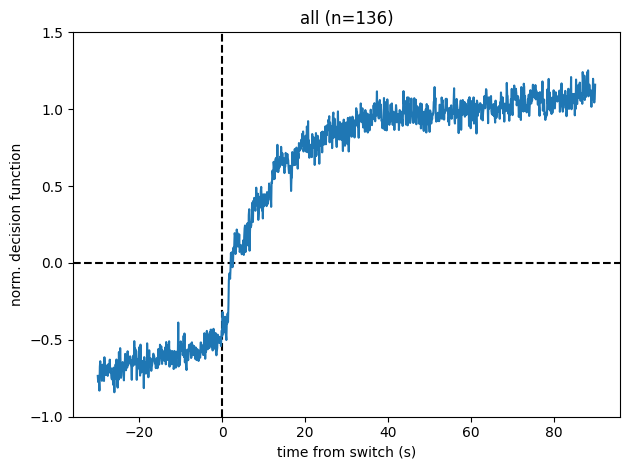

In [116]:
sel_area='all'

bins_before=300
bins_after=900
timebins=np.arange(-bins_before*bin_size,bins_after*bin_size,bin_size)

sel_switches=switch_aligned_decoding_df.query('structure==@sel_area and before_dprime>=1 and after_dprime>=1')['decision_function_all']

switch_by_timebin=np.vstack(sel_switches.values)
mean_switch_by_timebin=np.nanmean(switch_by_timebin,axis=0)
sem_switch_by_timebin=st.sem(switch_by_timebin,axis=0,nan_policy='omit')

fig,ax=plt.subplots(1,1)
ax.axvline(0,color='k',linestyle='--')
ax.axhline(0,color='k',linestyle='--')
ax.plot(timebins,-mean_switch_by_timebin)
# ax.fill_between(timebins,mean_switch_by_timebin-sem_switch_by_timebin,mean_switch_by_timebin+sem_switch_by_timebin,alpha=0.5)
ax.set_xlabel('time from switch (s)')
ax.set_ylabel('norm. decision function')
ax.set_title(sel_area+' (n='+str(len(sel_switches))+')')
# ax.set_xlim([-5,25])
ax.set_ylim([-1,1.5])
fig.tight_layout()

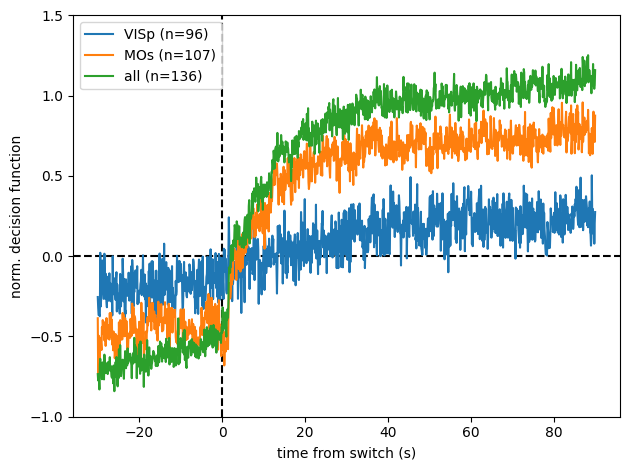

In [122]:
sel_areas=['VISp','MOs','all']

area_n=[]

bins_before=300
bins_after=900
timebins=np.arange(-bins_before*bin_size,bins_after*bin_size,bin_size)

fig,ax=plt.subplots(1,1)
ax.axvline(0,color='k',linestyle='--')
ax.axhline(0,color='k',linestyle='--')

for sel_area in sel_areas:
    sel_switches=switch_aligned_decoding_df.query('structure==@sel_area and before_dprime>=1 and after_dprime>=1')['decision_function_all']

    switch_by_timebin=np.vstack(sel_switches.values)
    mean_switch_by_timebin=np.nanmean(switch_by_timebin,axis=0)
    sem_switch_by_timebin=st.sem(switch_by_timebin,axis=0,nan_policy='omit')
    area_n.append(len(sel_switches))

    ax.plot(timebins,-mean_switch_by_timebin,label=sel_area+' (n='+str(len(sel_switches))+')')
# ax.fill_between(timebins,mean_switch_by_timebin-sem_switch_by_timebin,mean_switch_by_timebin+sem_switch_by_timebin,alpha=0.5)
ax.set_xlabel('time from switch (s)')
ax.set_ylabel('norm. decision function')
# ax.set_title(sel_area+' (n='+str(len(sel_switches))+')')
# ax.set_xlim([-5,25])
ax.set_ylim([-1,1.5])
ax.legend()
fig.tight_layout()

In [97]:
# all unique areas in results
all_areas=[]
for sel_session in range(0,len(svc_results)):
    all_areas.append(list(svc_results[sel_session]['block_ids'].keys()))
    
all_areas=np.unique(np.hstack(all_areas))
all_areas

array(['ACAd', 'ACAv', 'EPd', 'FRP', 'GU', 'MB', 'MOp', 'MOs', 'MPT',
       'NPC', 'ORBl', 'ORBvl', 'RSPd', 'RSPv', 'SCsg', 'SSp', 'VISam',
       'all', 'ccg', 'ec', 'root'], dtype='<U5')

In [3]:
#align to feedback - i.e. hit vs. false alarm

#include crs??

feedback_aligned_decoding={
    'session_id':[],
    'trial_index':[],
    'is_switch_trial':[],
    'trials_since_feedback':[],
    'trials_since_switch':[],
    'trials_since_reward':[],
    'is_hit':[],
    'is_false_alarm':[],
    'is_correct_reject':[],
    'stim_name':[],
    'context_name':[],
    'structure':[],
    'n_units':[],
    'block_dprime':[],
    'decision_function_20':[],
    'decision_function_all':[],
    'decision_function_stim_aligned_20':[],
    'decision_function_stim_aligned_all':[],
}

#load session
for ii,ff in enumerate(decoder_results[:]):
    with open(os.path.join(loadpath,ff),'rb') as handle:
        svc_results=pickle.load(handle)
    print(ff)

    all_areas=np.unique(list(svc_results['block_ids'].keys()))
    timepoints=[0]
    label_list=['vis','aud']
    predict=['block_ids']
    n_units=svc_results['unit_numbers']
    unit_numbers=np.arange(0,len(n_units))
    n_repeats=svc_results['n_repeats']

    #extract decision functions
    
    timebin=0
    predict=['block_ids']
    dec_func={}
    dec_func_shuffle={}

    for p in predict:
        dec_func[p]={}
        dec_func_shuffle[p]={}
        for n_units in unit_numbers:
            dec_func[p][n_units]={}
            dec_func_shuffle[p][n_units]={}
            for aa in all_areas:
                if aa in svc_results[p].keys():
                    dec_func[p][n_units][aa]={}
                    dec_func_shuffle[p][n_units][aa]={}
                    if len(svc_results[p][aa][timebin][n_units])>0:
                        dec_func_all=[]
                        dec_func_shuffle_all=[]
                        for repeat in range(0,n_repeats):
                            dec_func[p][n_units][aa][repeat]=svc_results[p][aa][timebin][n_units][repeat]['decision_function']
                            dec_func_shuffle[p][n_units][aa][repeat]=svc_results[p][aa][timebin][n_units][repeat]['shuffle']['decision_function']
                            dec_func_all.append(dec_func[p][n_units][aa][repeat])
                            dec_func_shuffle_all.append(dec_func_shuffle[p][n_units][aa][repeat])
                        
                        dec_func[p][n_units][aa]['average']=np.nanmean(np.vstack(dec_func_all),axis=0)
                        dec_func_shuffle[p][n_units][aa]['average']=np.nanmean(np.vstack(dec_func_shuffle_all),axis=0)

    #align results to switch times
    all_areas=np.unique(np.hstack(all_areas))
    unit_numbers=np.arange(0,len(svc_results['unit_numbers']))

    decoder_conf_context_switch={}
    # loop through areas
    for aa in all_areas:
        decoder_conf_context_switch[aa]={}
        # loop through n units
        for n_units in unit_numbers:
            decoder_conf_context_switch[aa][n_units]=[]

    session_id=svc_results['metadata'].session_id
    print(session_id)
    #load session table
    session=DynamicRoutingSession(session_id)
    # trials=session.trials[:]
    try:
        trials=pd.read_parquet(
                    npc_lims.get_cache_path('trials',session.id,version='any')
                )
        performance=pd.read_parquet(
                    npc_lims.get_cache_path('performance',session.id,version='any')
               )
    except:
        try:
            trials=session.trials[:]
            performance=session.performance[:]
        except:
            print(session_id,'failed; skipping')
            continue

    bin_size=0.1
    timebins_table,bins=spike_utils.make_timebins_table(trials, bin_size)


    ###TODO: match up timebin index with trials
    ### or put more info into timebins table


    # context_switch_index=timebins_table.query('is_context_switch').index.values


    ###TODO: change to include aall targets, ignore the CR-response aligned trials - or append nans/empty?
    target_feedback_index=trials.query('is_target').index.values

    # switch_aligned_decoding={}

    # # loop through areas
    # for aa in all_areas:
    #     switch_aligned_decoding[aa]={}

    #     # loop through n units
    #     for n_units in unit_numbers:
    #         switch_aligned_decoding[aa][n_units]=[]

    # #get pre/post switch dprime
    context_switch_trials=trials.query('is_context_switch')
    # cross_modal_dprime=performance[:]['cross_modal_dprime'].values
    bins_before=50
    bins_after=100
    p='block_ids'
    last_reward=np.nan

    for aa in all_areas:
        for tt,rc in enumerate(target_feedback_index):
            
            trialbins=timebins_table.query('trial_index==@rc')
            response_index=trialbins.query('response').index.values
            stim_start_index=trialbins.query('stim_start').index.values
            if len(response_index)==0:
                response_index=np.nan
            elif len(response_index)>0:
                response_index=response_index[0]
            if len(stim_start_index)==0:
                continue
            elif len(stim_start_index)>0:
                stim_start_index=stim_start_index[0]

            if trials['is_vis_context'].iloc[rc]:
                multiplier=1
            elif trials['is_aud_context'].iloc[rc]:
                multiplier=-1

            #get block index
            block_index=trials['block_index'].iloc[rc]
            
            #get block dprime
            block_dprime=performance.query('block_index==@block_index')['cross_modal_dprime'].values[0]

            #get stim name
            stim_name=trials['stim_name'].iloc[rc]
            
            #get response type
            is_hit=trials['is_hit'].iloc[rc]
            is_false_alarm=trials['is_false_alarm'].iloc[rc]
            is_correct_reject=trials['is_correct_reject'].iloc[rc]
            
            #get context name
            context_name=trials['context_name'].iloc[rc]

            #get is_switch
            is_switch_trial=trials['is_context_switch'].iloc[rc]

            #get trials since switch
            if block_index==0:
                trials_since_switch=rc
            else:
                trials_since_switch=rc-trials.query('block_index==@block_index').index.values[0]

            #get trials since last feedback
            if tt==0:
                trials_since_feedback=np.nan
            else:
                trials_since_feedback=rc-target_feedback_index[tt-1]

            #get trials since last reward
            if np.isnan(last_reward):
                trials_since_reward=np.nan
            else:
                trials_since_reward=rc-last_reward


            feedback_aligned_decoding['session_id'].append(session.id)
            feedback_aligned_decoding['structure'].append(aa)
            feedback_aligned_decoding['n_units'].append(svc_results['block_ids'][aa]['n_units'])
            feedback_aligned_decoding['block_dprime'].append(block_dprime)
            feedback_aligned_decoding['is_hit'].append(is_hit)
            feedback_aligned_decoding['is_false_alarm'].append(is_false_alarm)
            feedback_aligned_decoding['is_correct_reject'].append(is_correct_reject)
            feedback_aligned_decoding['is_switch_trial'].append(is_switch_trial)
            feedback_aligned_decoding['stim_name'].append(stim_name)
            feedback_aligned_decoding['context_name'].append(context_name)
            feedback_aligned_decoding['trial_index'].append(rc)
            feedback_aligned_decoding['trials_since_feedback'].append(trials_since_feedback)
            feedback_aligned_decoding['trials_since_switch'].append(trials_since_switch)
            feedback_aligned_decoding['trials_since_reward'].append(trials_since_reward)

            #align to stimulus and reward
            for n_units in unit_numbers:
                if np.isnan(response_index):
                    temp_bin_decoding=[]
                else:
                    temp_bin_decoding=(dec_func['block_ids'][n_units][aa]['average'][response_index-bins_before:response_index+bins_after]
                                /np.nanstd(dec_func['block_ids'][n_units][aa]['average'][response_index-bins_before:response_index+bins_after]))*multiplier
                dec_func_str='decision_function_'+str(svc_results['unit_numbers'][n_units])
                feedback_aligned_decoding[dec_func_str].append(temp_bin_decoding)

                temp_bin_decoding=(dec_func['block_ids'][n_units][aa]['average'][stim_start_index-bins_before:stim_start_index+bins_after]
                            /np.nanstd(dec_func['block_ids'][n_units][aa]['average'][stim_start_index-bins_before:stim_start_index+bins_after]))*multiplier
                dec_func_str='decision_function_stim_aligned_'+str(svc_results['unit_numbers'][n_units])
                feedback_aligned_decoding[dec_func_str].append(temp_bin_decoding)

            if trials['is_rewarded'].iloc[rc]:
                last_reward=rc

    # feedback_aligned_decoding[aa][n_units]=np.vstack(switch_aligned_decoding[aa][n_units])


# #save to a dictionary/dataframe
# feedback_aligned_decoding=pd.DataFrame.from_dict(feedback_aligned_decoding)
    

626791_2022-08-15_0_decode_timebins.pkl
626791_2022-08-15


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)


trialSoundArray empty; regenerating sound arrays


aligning sound waveforms: 100%|████████████| 479/479 [01:17<00:00,  6.20trial/s]
No lick time found within response window on sync for trial 145, despite being marked as a response trial.
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\s

626791_2022-08-17_0_decode_timebins.pkl
626791_2022-08-17


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 512/512 [01:10<00:00,  7.30trial/s]
No lick time found within response window on sync for trial 8, despite being marked as a response trial.
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddo

636766_2023-01-23_0_decode_timebins.pkl
636766_2023-01-23


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning opto waveforms: 100%|█████████████| 531/531 [02:37<00:00,  3.36trial/s]
No known opto location data found
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfuncti

636766_2023-01-24_0_decode_timebins.pkl
636766_2023-01-24


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning opto waveforms: 100%|█████████████| 533/533 [02:44<00:00,  3.24trial/s]
No known opto location data found
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfuncti

636766_2023-01-25_0_decode_timebins.pkl
636766_2023-01-25


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning opto waveforms: 100%|█████████████| 549/549 [02:53<00:00,  3.17trial/s]
No known opto location data found
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfuncti

636766_2023-01-26_0_decode_timebins.pkl
636766_2023-01-26


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning opto waveforms: 100%|█████████████| 543/543 [02:50<00:00,  3.18trial/s]
No known opto location data found
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfuncti

644864_2023-01-30_0_decode_timebins.pkl
644864_2023-01-30


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 535/535 [01:20<00:00,  6.64trial/s]
No lick time found within response window on sync for trial 392, despite being marked as a response trial.
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=d

644864_2023-01-31_0_decode_timebins.pkl
644864_2023-01-31


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 515/515 [01:18<00:00,  6.57trial/s]
No lick time found within response window on sync for trial 176, despite being marked as a response trial.
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=d

644864_2023-02-01_0_decode_timebins.pkl
644864_2023-02-01


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 527/527 [01:18<00:00,  6.68trial/s]
No lick time found within response window on sync for trial 84, despite being marked as a response trial.
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=dd

644864_2023-02-02_0_decode_timebins.pkl
644864_2023-02-02


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 513/513 [01:13<00:00,  6.96trial/s]
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degre

644866_2023-02-07_0_decode_timebins.pkl
644866_2023-02-07


aligning sound waveforms:  90%|██████████▊ | 420/467 [00:58<00:04, 10.25trial/s]Requested range 119253626 to 119268641 on nidaq_channel=1 is out of bounds: nidaq_data.shape=(119186320, 8)
No sound recording for trial 421 aud stim (presentation.trigger_time_on_sync=4151.89958 s) - setting latency=np.nan
aligning sound waveforms:  90%|██████████▊ | 422/467 [00:58<00:04,  9.34trial/s]No sound recording for trial 422 aud stim (presentation.trigger_time_on_sync=4157.93796 s) - setting latency=np.nan
No sound recording for trial 423 aud stim (presentation.trigger_time_on_sync=4165.3274 s) - setting latency=np.nan
No sound recording for trial 427 aud stim (presentation.trigger_time_on_sync=4190.84857 s) - setting latency=np.nan
No sound recording for trial 428 aud stim (presentation.trigger_time_on_sync=4199.02204 s) - setting latency=np.nan
No sound recording for trial 429 aud stim (presentation.trigger_time_on_sync=4204.84352 s) - setting latency=np.nan
No sound recording for trial 431 aud 

644866_2023-02-09_0_decode_timebins.pkl
644866_2023-02-09


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 539/539 [01:20<00:00,  6.69trial/s]
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degre

644866_2023-02-10_0_decode_timebins.pkl
644866_2023-02-10


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 528/528 [01:21<00:00,  6.45trial/s]
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degre

644867_2023-02-20_0_decode_timebins.pkl
644867_2023-02-20


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 534/534 [01:21<00:00,  6.58trial/s]
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degre

644867_2023-02-22_0_decode_timebins.pkl
644867_2023-02-22


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 529/529 [01:21<00:00,  6.50trial/s]
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degre

644867_2023-02-23_0_decode_timebins.pkl
644867_2023-02-23


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 537/537 [01:19<00:00,  6.72trial/s]
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degre

649943_2023-02-13_0_decode_timebins.pkl
649943_2023-02-13


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 524/524 [01:19<00:00,  6.58trial/s]
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degre

649943_2023-02-14_0_decode_timebins.pkl
649943_2023-02-14


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 540/540 [01:23<00:00,  6.45trial/s]
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degre

649943_2023-02-15_0_decode_timebins.pkl
649943_2023-02-15


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 547/547 [01:21<00:00,  6.75trial/s]
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degre

649943_2023-02-16_0_decode_timebins.pkl
649943_2023-02-16


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 534/534 [01:19<00:00,  6.68trial/s]
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degre

660023_2023-08-09_0_decode_timebins.pkl
660023_2023-08-09


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 501/501 [01:14<00:00,  6.69trial/s]
No lick time found within response window on sync for trial 478, despite being marked as a response trial.
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=d

662892_2023-08-21_0_decode_timebins.pkl
662892_2023-08-21


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 490/490 [01:15<00:00,  6.51trial/s]
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degre

662892_2023-08-22_0_decode_timebins.pkl
662892_2023-08-22


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 522/522 [01:19<00:00,  6.58trial/s]
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degre

662892_2023-08-23_0_decode_timebins.pkl
662892_2023-08-23


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 470/470 [01:13<00:00,  6.38trial/s]
No lick time found within response window on sync for trial 175, despite being marked as a response trial.
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=d

662892_2023-08-24_0_decode_timebins.pkl
662892_2023-08-24


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 476/476 [01:12<00:00,  6.57trial/s]
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degre

666986_2023-08-15_0_decode_timebins.pkl
666986_2023-08-15


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 542/542 [01:15<00:00,  7.20trial/s]
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degre

667252_2023-09-27_0_decode_timebins.pkl
667252_2023-09-27


Session 667252_2023-09-27 has known issues: ['https://github.com/AllenInstitute/npc_sessions/issues/55']
No lick time found within response window on sync for trial 135, despite being marked as a response trial.
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3

667252_2023-09-28_0_decode_timebins.pkl
667252_2023-09-28


No lick time found within response window on sync for trial 204, despite being marked as a response trial.
No lick time found within response window on sync for trial 437, despite being marked as a response trial.
No lick time found within response window on sync for trial 461, despite being marked as a response trial.
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: 

668755_2023-08-28_0_decode_timebins.pkl
668755_2023-08-28


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 533/533 [01:14<00:00,  7.15trial/s]
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degre

668755_2023-08-29_0_decode_timebins.pkl
668755_2023-08-29


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 520/520 [01:16<00:00,  6.78trial/s]
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degre

668755_2023-08-30_0_decode_timebins.pkl
668755_2023-08-30


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 513/513 [01:11<00:00,  7.14trial/s]
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degre

668755_2023-08-31_0_decode_timebins.pkl
668755_2023-08-31


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis

674562_2023-10-02_0_decode_timebins.pkl
674562_2023-10-02


No lick time found within response window on sync for trial 333, despite being marked as a response trial.
No lick time found within response window on sync for trial 416, despite being marked as a response trial.
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anacond

674562_2023-10-03_0_decode_timebins.pkl
674562_2023-10-03


No lick time found within response window on sync for trial 17, despite being marked as a response trial.
No lick time found within response window on sync for trial 297, despite being marked as a response trial.
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda

674562_2023-10-04_0_decode_timebins.pkl
674562_2023-10-04


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis

674562_2023-10-05_0_decode_timebins.pkl
674562_2023-10-05


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis

681532_2023-10-16_0_decode_timebins.pkl
681532_2023-10-16


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis

681532_2023-10-17_0_decode_timebins.pkl
681532_2023-10-17


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis

681532_2023-10-18_0_decode_timebins.pkl
681532_2023-10-18


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\npc_analysis

In [8]:
# for key in feedback_aligned_decoding.keys():
#     print(key,len(feedback_aligned_decoding[key]))

is_correct_reject_vect=[]

for xx in range(len(feedback_aligned_decoding['is_hit'])):
    if feedback_aligned_decoding['is_hit'][xx]==False and feedback_aligned_decoding['is_false_alarm'][xx]==False:
        is_correct_reject_vect.append(True)
    else:
        is_correct_reject_vect.append(False)

In [11]:
feedback_aligned_decoding['is_correct_reject']=is_correct_reject_vect

In [12]:
feedback_aligned_decoding_df=pd.DataFrame.from_dict(feedback_aligned_decoding)
feedback_aligned_decoding_df

,session_id,trial_index,is_switch_trial,trials_since_feedback,trials_since_switch,trials_since_reward,is_hit,is_false_alarm,is_correct_reject,stim_name,context_name,structure,n_units,block_dprime,decision_function_20,decision_function_all,decision_function_stim_aligned_20,decision_function_stim_aligned_all
0,626791_2022-08-15,0,False,NaN,0,NaN,True,False,False,vis1,vis,AUDp,76,2.974365,[],[],[],[]
1,626791_2022-08-15,1,False,1.0,1,1.0,True,False,False,vis1,vis,AUDp,76,2.974365,"[2.5660838381426245, 1.0506331292475708, 1.679...","[2.9093709945320505, 1.085147453222314, 1.3978...","[0.8750125358671419, -0.6441360809648636, 0.78...","[1.0115108827146309, -0.762317200123621, 1.008..."
2,626791_2022-08-15,2,False,1.0,2,1.0,True,False,False,vis1,vis,AUDp,76,2.974365,"[0.2667425627707338, 0.5109103375324104, 1.241...","[-0.4506989627043827, 0.2869513908727941, 1.15...","[1.1233717077370964, 0.7618880078528095, 1.053...","[0.7405885103567245, 0.5265712825215929, 0.659..."
3,626791_2022-08-15,3,False,1.0,3,1.0,True,False,False,vis1,vis,AUDp,76,2.974365,"[2.1436368590302455, 1.9079966073051606, 0.126...","[1.24930774508452, 0.8507051418623188, -0.3751...","[1.2625590968196925, 1.55970698250613, 1.47415...","[0.3890095158403112, 0.7424946022162031, 1.685..."
4,626791_2022-08-15,4,False,1.0,4,1.0,True,False,False,vis1,vis,AUDp,76,2.974365,"[0.3855012407972667, -0.33639787966019424, -0....","[0.27982562794920174, -0.6182277603327655, -0....","[-0.23464955929185663, 0.8261188241115123, 0.0...","[-0.2794071819904387, 0.7383019559548442, -0.2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150688,681532_2023-10-18,489,False,5.0,62,9.0,False,True,False,vis1,aud,all,2093,0.930759,"[0.5673475571946517, 0.48800373504989525, 0.65...","[0.033703558454920464, 2.0033141391407514, 1.5...","[1.3200663250737141, 0.39959054560083784, 0.17...","[0.356204447240258, 0.9187127941941268, 0.9921..."
150689,681532_2023-10-18,490,False,1.0,63,10.0,True,False,False,sound1,aud,all,2093,0.930759,"[2.0226645031900055, 1.9304579842460754, -0.30...","[1.837492909103332, 1.0896203184501987, 0.9900...","[0.6605986762353961, 0.2603500294976549, 1.656...","[0.6539801653039145, 1.0438793135459132, 2.716..."
150690,681532_2023-10-18,492,False,2.0,65,2.0,False,False,True,vis1,aud,all,2093,0.930759,[],[],"[2.602463913429173, 2.7680864995497654, 2.0645...","[3.2036040012595244, 3.82975170627748, 1.71602..."
150691,681532_2023-10-18,493,False,1.0,66,3.0,True,False,False,sound1,aud,all,2093,0.930759,"[0.8406932973424588, -0.09177884429889523, 0.1...","[1.4071685467360027, 0.35289370681071025, 1.11...","[-0.0937230388801533, 0.9974707632934305, 0.41...","[1.7028770599088834, 1.1409197139203038, 1.683..."


In [13]:
feedback_aligned_decoding_df.to_pickle(r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\DR decoding results\timebins\feedback_aligned_decoding_w_cr.pkl")

In [140]:
test=feedback_aligned_decoding_df.query('structure=="MOs" and is_false_alarm==True and block_dprime>=1.0')['decision_function_stim_aligned_all'].values
test2=[]

for df in test:
    # print(len(df))
    if len(df)==bins_before+bins_after:
        test2.append(df)

test2=np.vstack(test2)

In [167]:
# test2.shape
# trials.query('is_rewarded and is_contingent_reward')['is_response'].mean()
trials.columns

Index(['start_time', 'stop_time', 'quiescent_start_time',
       'quiescent_stop_time', 'stim_start_time', 'stim_stop_time',
       'response_window_start_time', 'response_window_stop_time',
       'task_control_response_time', 'response_time', 'reward_time',
       'post_response_window_start_time', 'post_response_window_stop_time',
       'stim_name', 'block_index', 'context_name', 'trial_index',
       'trial_index_in_block', 'repeat_index', 'is_response', 'is_correct',
       'is_incorrect', 'is_hit', 'is_false_alarm', 'is_correct_reject',
       'is_miss', 'is_go', 'is_nogo', 'is_rewarded', 'is_noncontingent_reward',
       'is_contingent_reward', 'is_reward_scheduled', 'is_aud_stim',
       'is_vis_stim', 'is_catch', 'is_target', 'is_aud_target',
       'is_vis_target', 'is_nontarget', 'is_aud_nontarget', 'is_vis_nontarget',
       'is_vis_context', 'is_aud_context', 'is_context_switch', 'is_repeat',
       'is_opto', 'session_idx', 'date', 'subject_id', 'session_id'],
      dtyp

Text(0.5, 0, 'time from stimulus (s)')

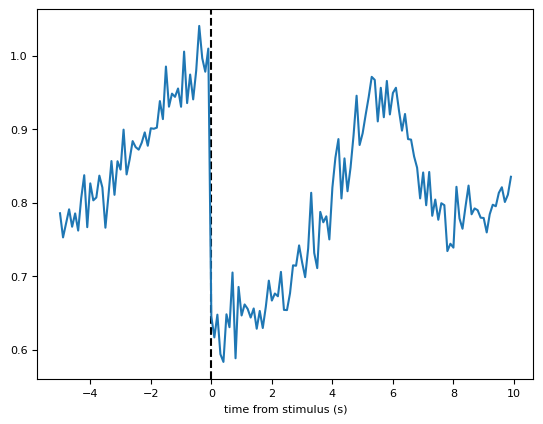

In [141]:
fig,ax=plt.subplots(1,1)
xvect=np.arange(-bins_before*bin_size,bins_after*bin_size,bin_size)
ax.axvline(0,color='k',linestyle='--')
ax.plot(xvect,np.nanmean(test2,axis=0))
ax.set_xlabel('time from stimulus (s)')

In [155]:
feedback_aligned_decoding_df['structure'].unique()

array(['AUDp', 'AUDpo', 'BST', 'CA1', 'CP', 'DG', 'IGL', 'LD', 'LGd',
       'LP', 'LPO', 'MOs', 'PO', 'PS', 'RSPd', 'STR', 'VISpm', 'VPM',
       'ZI', 'all', 'MOp', 'PoT', 'SGN', 'TEa', 'VISam', 'VISli', 'VISp',
       'ACB', 'AId', 'AIv', 'SUB', 'PIR', 'PRE', 'LSr', 'MRN', 'POL',
       'POST', 'RSPagl', 'RSPv', 'SF', 'VISa', 'cing', 'APN', 'ILA',
       'MGm', 'ORBm', 'SCig', 'SCiw', 'VISl', 'MB', 'ProS', 'or', 'CA3',
       'LH', 'LSv', 'MD', 'VISrl', 'ACAd', 'ACAv', 'fp', 'Eth', 'MGd',
       'MGv', 'RT', 'SSp', 'ccb', 'scwm', 'ICd', 'ICe', 'SAG', 'VISpor',
       'VL', 'HPF', 'SCdg', 'SNr', 'int', 'root', 'PIL', 'VPL', 'PAG',
       'VAL', 'VM', 'AQ', 'EPd', 'OT', 'PPN', 'PRNr', 'SCsg', 'cpd', 'CS',
       'ORBl', 'P', 'PG', 'TRN', 'ml', 'MPT', 'OLF', 'fa', 'AMv', 'LSc',
       'MS', 'PR', 'PVH', 'TH', 'FRP', 'GU', 'NPC', 'ORBvl', 'ccg', 'ec',
       'AON', 'LGv', 'TRS', 'SSs', 'VISal', 'DP', 'AD', 'AV', 'CL', 'ar',
       'AUDd'], dtype=object)

Text(0.5, 0.98, 'AId; vis context')

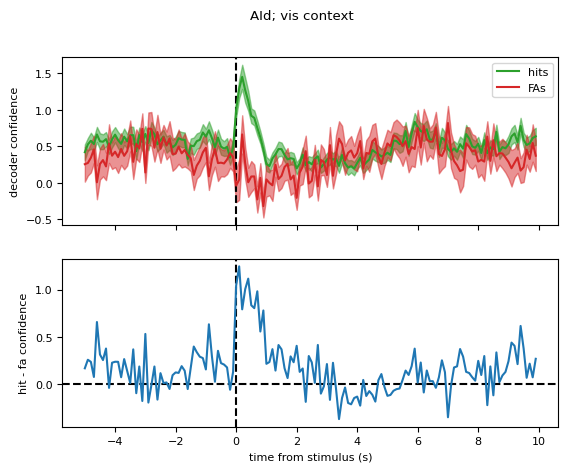

In [213]:
sel_area='AId'
sel_context="vis"

hit_vals=feedback_aligned_decoding_df.query('structure==@sel_area and is_hit==True and block_dprime>=1.0 and context_name==@sel_context')['decision_function_stim_aligned_all'].values
hits=[]
for xx in hit_vals:
    if len(xx)==bins_before+bins_after:
        hits.append(xx)
hits=np.vstack(hits)

fa_vals=feedback_aligned_decoding_df.query('structure==@sel_area and is_false_alarm==True and block_dprime>=1.0 and context_name==@sel_context')['decision_function_stim_aligned_all'].values
fas=[]
for xx in fa_vals:
    if len(xx)==bins_before+bins_after:
        fas.append(xx)
fas=np.vstack(fas)

hit_fa_diff=np.nanmean(hits,axis=0)-np.nanmean(fas,axis=0)

fig,ax=plt.subplots(2,1,sharex=True)
xvect=np.arange(-bins_before*bin_size,bins_after*bin_size,bin_size)
ax[0].axvline(0,color='k',linestyle='--')
ax[0].plot(xvect,np.nanmean(hits,axis=0),'tab:green',label='hits')
ax[0].fill_between(xvect,np.nanmean(hits,axis=0)-st.sem(hits,axis=0,nan_policy='omit'),np.nanmean(hits,axis=0)+st.sem(hits,axis=0,nan_policy='omit'),color='tab:green',alpha=0.5)
ax[0].plot(xvect,np.nanmean(fas,axis=0),'tab:red',label='FAs')
ax[0].fill_between(xvect,np.nanmean(fas,axis=0)-st.sem(fas,axis=0,nan_policy='omit'),np.nanmean(fas,axis=0)+st.sem(fas,axis=0,nan_policy='omit'),color='tab:red',alpha=0.5)
ax[0].set_ylabel('decoder confidence')
ax[0].legend()

ax[1].axvline(0,color='k',linestyle='--')
ax[1].axhline(0,color='k',linestyle='--')
ax[1].set_ylabel('hit - fa confidence')
ax[1].set_xlabel('time from stimulus (s)')
ax[1].plot(xvect,hit_fa_diff)

fig.suptitle(sel_area+'; '+sel_context+' context')

Text(0.5, 0.98, 'ORBm; stimulus=vis1')

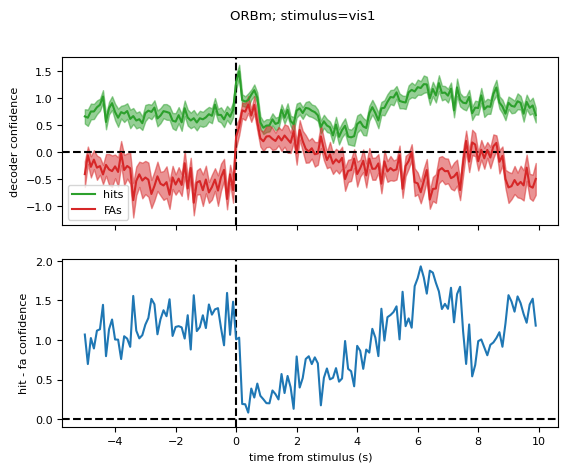

In [220]:
sel_area='ORBm'
sel_stim="vis1"

hit_vals=feedback_aligned_decoding_df.query('structure==@sel_area and is_hit==True and block_dprime>=1.0 and stim_name==@sel_stim')['decision_function_stim_aligned_all'].values
hits=[]
for xx in hit_vals:
    if len(xx)==bins_before+bins_after:
        hits.append(xx)
hits=np.vstack(hits)

fa_vals=-feedback_aligned_decoding_df.query('structure==@sel_area and is_false_alarm==True and block_dprime>=1.0 and stim_name==@sel_stim')['decision_function_stim_aligned_all'].values
fas=[]
for xx in fa_vals:
    if len(xx)==bins_before+bins_after:
        fas.append(xx)
fas=np.vstack(fas)

hit_fa_diff=np.nanmean(hits,axis=0)-np.nanmean(fas,axis=0)

fig,ax=plt.subplots(2,1,sharex=True)
xvect=np.arange(-bins_before*bin_size,bins_after*bin_size,bin_size)
ax[0].axvline(0,color='k',linestyle='--')
ax[0].axhline(0,color='k',linestyle='--')
ax[0].plot(xvect,np.nanmean(hits,axis=0),'tab:green',label='hits')
ax[0].fill_between(xvect,np.nanmean(hits,axis=0)-st.sem(hits,axis=0,nan_policy='omit'),np.nanmean(hits,axis=0)+st.sem(hits,axis=0,nan_policy='omit'),color='tab:green',alpha=0.5)
ax[0].plot(xvect,np.nanmean(fas,axis=0),'tab:red',label='FAs')
ax[0].fill_between(xvect,np.nanmean(fas,axis=0)-st.sem(fas,axis=0,nan_policy='omit'),np.nanmean(fas,axis=0)+st.sem(fas,axis=0,nan_policy='omit'),color='tab:red',alpha=0.5)
ax[0].set_ylabel('decoder confidence')
ax[0].legend()

ax[1].axvline(0,color='k',linestyle='--')
ax[1].axhline(0,color='k',linestyle='--')
ax[1].set_ylabel('hit - fa confidence')
ax[1].set_xlabel('time from stimulus (s)')
ax[1].plot(xvect,hit_fa_diff)

fig.suptitle(sel_area+'; stimulus='+sel_stim)

Text(0.5, 0.98, 'AId; stimulus=vis1')

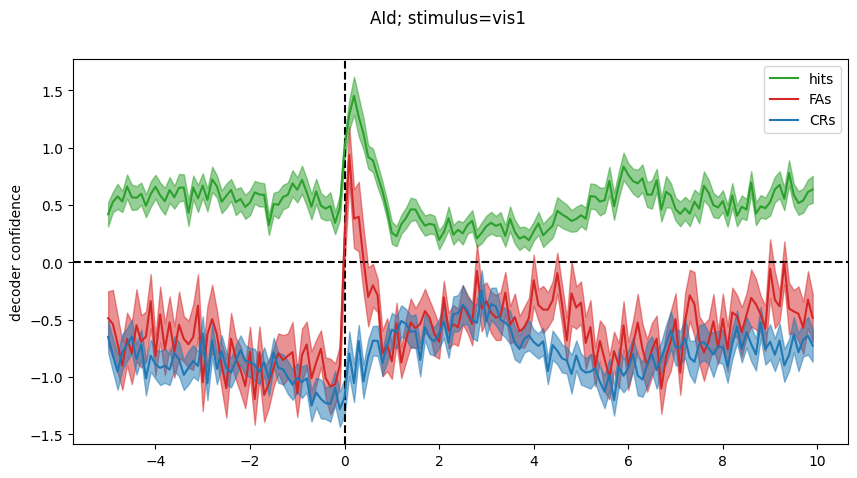

In [22]:
sel_area='AId'
sel_stim="vis1"

hit_vals=feedback_aligned_decoding_df.query('structure==@sel_area and is_hit==True and block_dprime>=1.0 and stim_name==@sel_stim')['decision_function_stim_aligned_all'].values
hits=[]
for xx in hit_vals:
    if len(xx)==bins_before+bins_after:
        hits.append(xx)
hits=np.vstack(hits)

fa_vals=-feedback_aligned_decoding_df.query('structure==@sel_area and is_false_alarm==True and block_dprime>=1.0 and stim_name==@sel_stim')['decision_function_stim_aligned_all'].values
fas=[]
for xx in fa_vals:
    if len(xx)==bins_before+bins_after:
        fas.append(xx)
fas=np.vstack(fas)

cr_vals=-feedback_aligned_decoding_df.query('structure==@sel_area and is_correct_reject==True and block_dprime>=1.0 and stim_name==@sel_stim')['decision_function_stim_aligned_all'].values
crs=[]
for xx in cr_vals:
    if len(xx)==bins_before+bins_after:
        crs.append(xx)
crs=np.vstack(crs)

# hit_fa_diff=np.nanmean(hits,axis=0)-np.nanmean(fas,axis=0)

fig,ax=plt.subplots(1,1,figsize=(10,5))
# fig,ax=plt.subplots(2,1,sharex=True)
xvect=np.arange(-bins_before*bin_size,bins_after*bin_size,bin_size)
ax.axvline(0,color='k',linestyle='--')
ax.axhline(0,color='k',linestyle='--')
ax.plot(xvect,np.nanmean(hits,axis=0),'tab:green',label='hits')
ax.fill_between(xvect,np.nanmean(hits,axis=0)-st.sem(hits,axis=0,nan_policy='omit'),np.nanmean(hits,axis=0)+st.sem(hits,axis=0,nan_policy='omit'),color='tab:green',alpha=0.5)
ax.plot(xvect,np.nanmean(fas,axis=0),'tab:red',label='FAs')
ax.fill_between(xvect,np.nanmean(fas,axis=0)-st.sem(fas,axis=0,nan_policy='omit'),np.nanmean(fas,axis=0)+st.sem(fas,axis=0,nan_policy='omit'),color='tab:red',alpha=0.5)
ax.plot(xvect,np.nanmean(crs,axis=0),'tab:blue',label='CRs')
ax.fill_between(xvect,np.nanmean(crs,axis=0)-st.sem(crs,axis=0,nan_policy='omit'),np.nanmean(crs,axis=0)+st.sem(crs,axis=0,nan_policy='omit'),color='tab:blue',alpha=0.5)
ax.set_ylabel('decoder confidence')
ax.legend()

# ax[1].axvline(0,color='k',linestyle='--')
# ax[1].axhline(0,color='k',linestyle='--')
# ax[1].set_ylabel('hit - fa confidence')
# ax[1].set_xlabel('time from stimulus (s)')
# ax[1].plot(xvect,hit_fa_diff)

fig.suptitle(sel_area+'; stimulus='+sel_stim)

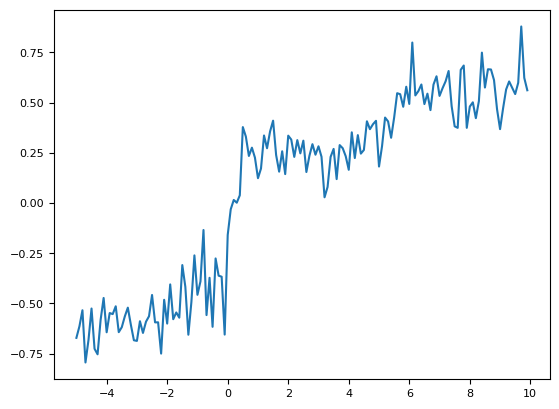

In [130]:
switch_trials=np.nanmedian(np.vstack(feedback_aligned_decoding_df.query('structure=="all" and is_switch_trial')['decision_function_stim_aligned_all'].values),axis=0)
fig,ax=plt.subplots(1,1)
ax.plot(xvect,switch_trials)

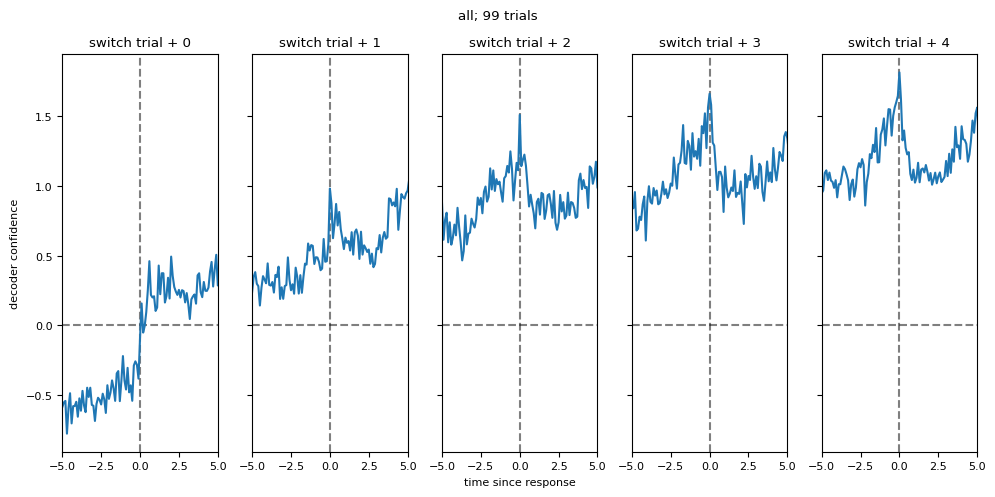

In [139]:
#plot 1st trial after switch, 2nd, 3rd, 4th, 5th in separate subplots

sel_area='all'
dprime_thresh=1.0

switch_trials=feedback_aligned_decoding_df.query('structure==@sel_area and is_switch_trial and block_dprime>=@dprime_thresh')
switch_trial_idx=switch_trials.index.values

plot_trials=np.arange(0,5)

fig,ax=plt.subplots(1,5,figsize=(10,5),sharey=True,sharex=True)

for pt in plot_trials:
    trial_idx=switch_trial_idx+pt
    trial_decoding=feedback_aligned_decoding_df.loc[trial_idx]['decision_function_stim_aligned_all'].values
    trial_decoding=np.vstack(trial_decoding)
    ax[pt].axvline(0,color='k',linestyle='--',alpha=0.5)
    ax[pt].axhline(0,color='k',linestyle='--',alpha=0.5)
    ax[pt].plot(xvect,np.nanmean(trial_decoding,axis=0))
    ax[pt].set_title('switch trial + '+str(pt))
    ax[pt].set_xlim([-5,5])

ax[2].set_xlabel('time since response')
ax[0].set_ylabel('decoder confidence')
fig.suptitle(sel_area+'; '+str(len(switch_trials))+' trials')
fig.tight_layout()



Text(0.5, 0, 'trials since feedback')

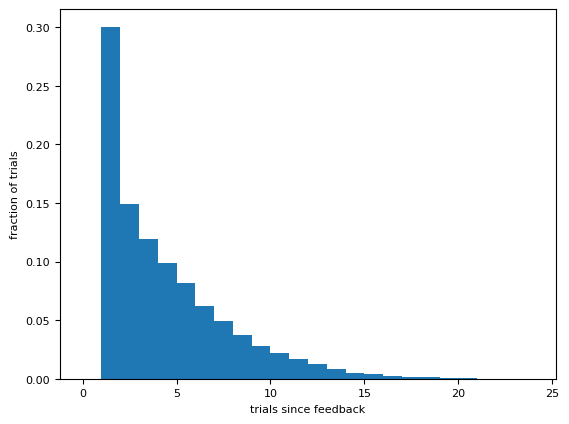

In [138]:
#trials since feedback histogram
fig,ax=plt.subplots(1,1)
ax.hist(feedback_aligned_decoding_df.query('structure=="all" and block_dprime>=1.0')['trials_since_reward'],bins=np.arange(0,25),density=True)
ax.set_ylabel('fraction of trials')
ax.set_xlabel('trials since feedback')

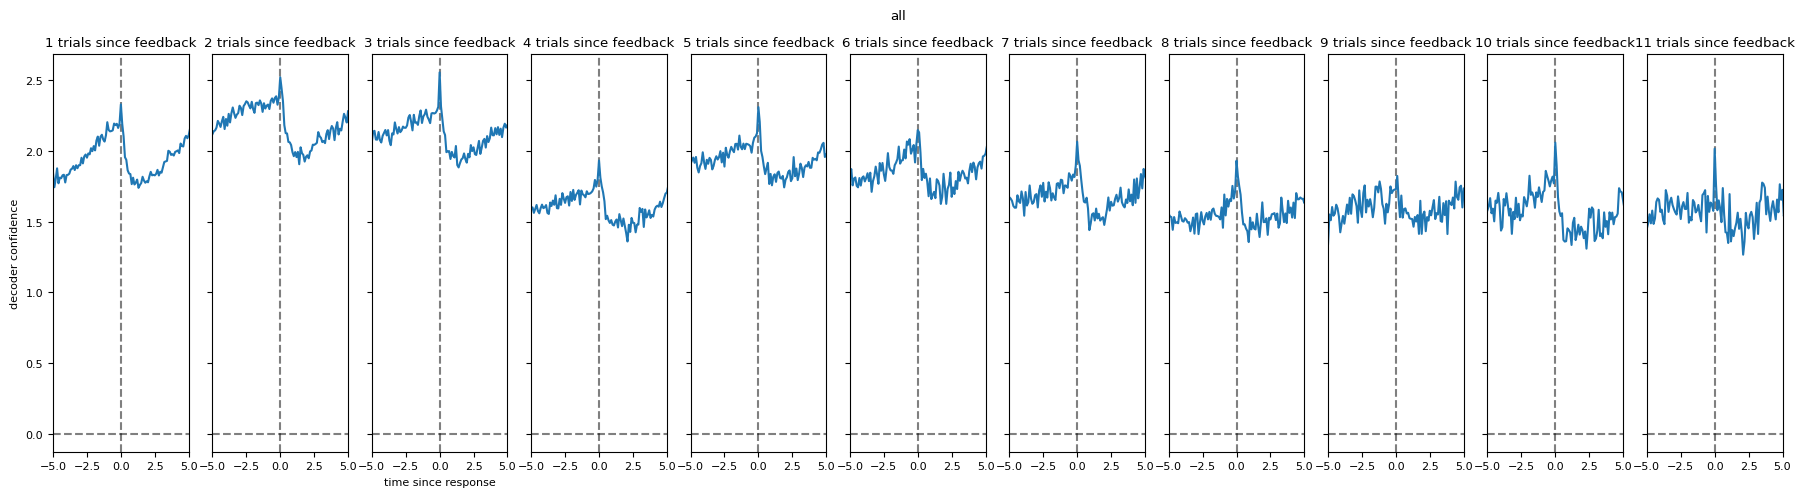

In [136]:
#plot trials as function of time since last reward or feedback

sel_area='all'
dprime_thresh=1.0

trials_since_feedback=np.arange(1,12)

fig,ax=plt.subplots(1,len(trials_since_feedback),figsize=(18,5),sharey=True,sharex=True)

for ft,feedback_trial in enumerate(trials_since_feedback):
    feedback_trials=feedback_aligned_decoding_df.query('structure==@sel_area and trials_since_reward==@feedback_trial and \
                                                        trials_since_switch>4')['decision_function_stim_aligned_all']
    trial_decoding=[]
    for trial in feedback_trials:
        if len(trial)==bins_before+bins_after:
            trial_decoding.append(trial)
    trial_decoding=np.vstack(trial_decoding)
    ax[ft].axvline(0,color='k',linestyle='--',alpha=0.5)
    ax[ft].axhline(0,color='k',linestyle='--',alpha=0.5)
    ax[ft].plot(xvect,np.nanmean(trial_decoding,axis=0))
    ax[ft].set_title(str(feedback_trial)+' trials since feedback')
    ax[ft].set_xlim([-5,5])

ax[2].set_xlabel('time since response')
ax[0].set_ylabel('decoder confidence')
fig.suptitle(sel_area)
fig.tight_layout()

In [97]:
ft

1

In [13]:
# feedback_aligned_decoding=pd.DataFrame.from_dict(feedback_aligned_decoding)
# feedback_aligned_decoding[:50]
timebins_table,bins=spike_utils.make_timebins_table(trials, bin_size)

In [14]:
timebins_table[:]

,bin_start,bin_end,bin_center,stim_start,stim_stop,reward,response,is_vis_context,is_aud_context,is_vis_stim,is_aud_stim,is_vis_target,is_aud_target,is_catch,is_vis_nontarget,is_aud_nontarget,is_context_switch,trial_index
0,85.7625,85.8625,85.8125,False,False,False,False,True,False,False,False,False,False,False,False,False,False,0.0
1,85.8625,85.9625,85.9125,False,False,False,False,True,False,False,False,False,False,False,False,False,False,0.0
2,85.9625,86.0625,86.0125,False,False,False,False,True,False,False,False,False,False,False,False,False,False,0.0
3,86.0625,86.1625,86.1125,False,False,False,False,True,False,False,False,False,False,False,False,False,False,0.0
4,86.1625,86.2625,86.2125,False,False,False,False,True,False,False,False,False,False,False,False,False,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35965,3682.2625,3682.3625,3682.3125,False,False,False,False,False,True,False,False,False,False,False,False,False,False,478.0
35966,3682.3625,3682.4625,3682.4125,False,False,False,False,False,True,False,False,False,False,False,False,False,False,478.0
35967,3682.4625,3682.5625,3682.5125,False,False,False,False,False,True,False,False,False,False,False,False,False,False,478.0
35968,3682.5625,3682.6625,3682.6125,False,False,False,False,False,True,False,False,False,False,False,False,False,False,478.0


In [22]:
# trialbins=timebins_table.query('trial_index==@rc')
# trialbins.query('response')
# response_index[0]
trialbins.query('response').index.values[0]

23

In [11]:
trials.query('is_response')['response_time']

id
0        87.97838
1        94.09598
2       100.34042
3       107.02306
4       113.56762
          ...    
470    3606.95364
473    3633.29201
474    3639.38711
476    3659.69843
478    3679.32326
Name: response_time, Length: 239, dtype: float64

In [10]:
trials.columns

Index(['start_time', 'stop_time', 'quiescent_start_time',
       'quiescent_stop_time', 'stim_start_time', 'stim_stop_time',
       'response_window_start_time', 'response_window_stop_time',
       'task_control_response_time', 'response_time', 'reward_time',
       'post_response_window_start_time', 'post_response_window_stop_time',
       'stim_name', 'block_index', 'context_name', 'trial_index',
       'trial_index_in_block', 'repeat_index', 'is_response', 'is_correct',
       'is_incorrect', 'is_hit', 'is_false_alarm', 'is_correct_reject',
       'is_miss', 'is_go', 'is_nogo', 'is_rewarded', 'is_noncontingent_reward',
       'is_contingent_reward', 'is_reward_scheduled', 'is_aud_stim',
       'is_vis_stim', 'is_catch', 'is_target', 'is_aud_target',
       'is_vis_target', 'is_nontarget', 'is_aud_nontarget', 'is_vis_nontarget',
       'is_vis_context', 'is_aud_context', 'is_context_switch', 'is_repeat',
       'is_opto', 'session_idx', 'date', 'subject_id', 'session_id'],
      dtyp

In [95]:
# len(svc_results)

8

In [98]:
# make into more plottable format

###TODO: make more general for different #'s of things

plot_results={}
plot_shuffle_results={}

timepoints=[0]

# label_list=['vis1','vis2','sound1','sound2','True','False']
# label_list=['vis1','sound1','True','False']
label_list=['vis','aud']

# predict=['stim_ids','block_ids','trial_response']
predict=['block_ids']

# areas=['VISp','AUD','LG','MG','MOs','MRN','CP','MOp']
areas=all_areas

n_units=svc_results[0]['unit_numbers']
unit_numbers=np.arange(0,len(n_units))
n_repeats=svc_results[0]['n_repeats']

for sel_session in range(0,len(svc_results)):
    plot_results[sel_session]={}
    plot_shuffle_results[sel_session]={}
    for aa in areas:
        plot_results[sel_session][aa]={}
        plot_shuffle_results[sel_session][aa]={}
        for p in predict:
            plot_results[sel_session][aa][p]={}
            plot_shuffle_results[sel_session][aa][p]={}
            for uu in unit_numbers:
                plot_results[sel_session][aa][p][uu]={}
                plot_shuffle_results[sel_session][aa][p][uu]={}
                for ll in label_list:
                    plot_results[sel_session][aa][p][uu][ll]=np.zeros((len(timepoints),svc_results[sel_session]['n_repeats']))
                    plot_results[sel_session][aa][p][uu][ll][:]=np.nan

                    plot_shuffle_results[sel_session][aa][p][uu][ll]=np.zeros((len(timepoints),svc_results[sel_session]['n_repeats']))
                    plot_shuffle_results[sel_session][aa][p][uu][ll][:]=np.nan

    
# diff table for each timepoint?
# row = session
# columns = ['modality','A_vis','A_aud','B_vis','B_aud','C_vis','C_aud','F_vis','F_aud',]

decoder_acc_session_mean = {}
decoder_acc_session_shuffle_mean = {}
decoder_acc_session_median = {}
decoder_acc_session_shuffle_median = {}

for aa in areas:
    decoder_acc_session_mean[aa]={}
    decoder_acc_session_shuffle_mean[aa]={}
    decoder_acc_session_median[aa]={}
    decoder_acc_session_shuffle_median[aa]={}
    for p in predict:
        decoder_acc_session_mean[aa][p]={}
        decoder_acc_session_shuffle_mean[aa][p]={}
        decoder_acc_session_median[aa][p]={}
        decoder_acc_session_shuffle_median[aa][p]={}
        for uu in unit_numbers:
            decoder_acc_session_mean[aa][p][uu]={}
            decoder_acc_session_shuffle_mean[aa][p][uu]={}
            decoder_acc_session_median[aa][p][uu]={}
            decoder_acc_session_shuffle_median[aa][p][uu]={}
            for ll in label_list:

                decoder_acc_session_mean[aa][p][uu][ll]=np.zeros((len(timepoints),
                                                               len(svc_results)))
                decoder_acc_session_mean[aa][p][uu][ll][:]=np.nan

                decoder_acc_session_shuffle_mean[aa][p][uu][ll]=np.zeros((len(timepoints),
                                                               len(svc_results)))
                decoder_acc_session_shuffle_mean[aa][p][uu][ll][:]=np.nan

                decoder_acc_session_median[aa][p][uu][ll]=np.zeros((len(timepoints),
                                                               len(svc_results)))
                decoder_acc_session_median[aa][p][uu][ll][:]=np.nan

                decoder_acc_session_shuffle_median[aa][p][uu][ll]=np.zeros((len(timepoints),
                                                               len(svc_results)))
                decoder_acc_session_shuffle_median[aa][p][uu][ll][:]=np.nan
        

for sel_session in range(0,len(svc_results)):
    for p in predict:
        for aa in areas: 
            if aa in svc_results[sel_session][p].keys():
                for tt,tp in enumerate(timepoints):
                    for uu in unit_numbers:
                        for nn in range(0,svc_results[sel_session]['n_repeats']):
                            for ll in label_list:
                                if len(svc_results[sel_session][p][aa])>0:
                                    if len(svc_results[sel_session][p][aa][tt])>0:
                                        if len(svc_results[sel_session][p][aa][tt][uu])>0:
                                            if ll in svc_results[sel_session][p][aa][tt][uu][nn]['cr'].keys():
                                                temp_perf=np.nanmean(
                                                    [svc_results[sel_session][p][aa][tt][uu][nn]['cr'][ll]['precision'],
                                                     svc_results[sel_session][p][aa][tt][uu][nn]['cr'][ll]['recall']]
                                                     )
                                                plot_results[sel_session][aa][p][uu][ll][tt,nn]=temp_perf

                                                temp_shuff_perf=np.nanmean(
                                                    [svc_results[sel_session][p][aa][tt][uu][nn]['shuffle']['cr'][ll]['precision'],
                                                     svc_results[sel_session][p][aa][tt][uu][nn]['shuffle']['cr'][ll]['recall']]
                                                     )
                                                plot_shuffle_results[sel_session][aa][p][uu][ll][tt,nn]=temp_shuff_perf

                            for ll in label_list:
                                if len(svc_results[sel_session][p][aa])>0:                    
                                    decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][uu][ll][tt])
                                    decoder_acc_session_mean[aa][p][uu][ll][tt,sel_session] = decoder_acc_mean

                                    decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][uu][ll][tt])
                                    decoder_acc_session_shuffle_mean[aa][p][uu][ll][tt,sel_session] = decoder_acc_shuffle_mean

                                    decoder_acc_median = np.nanmedian(plot_results[sel_session][aa][p][uu][ll][tt])
                                    decoder_acc_session_median[aa][p][uu][ll][tt,sel_session] = decoder_acc_median

                                    decoder_acc_shuffle_median = np.nanmedian(plot_shuffle_results[sel_session][aa][p][uu][ll][tt])
                                    decoder_acc_session_shuffle_median[aa][p][uu][ll][tt,sel_session] = decoder_acc_shuffle_median

dec_func={}
dec_func_shuffle={}
timebin=0

predict=['block_ids']

for sel_session in range(0,len(svc_results)):

    dec_func[sel_session]={}
    dec_func_shuffle[sel_session]={}

    for p in predict:
        dec_func[sel_session][p]={}
        dec_func_shuffle[sel_session][p]={}
        for n_units in unit_numbers:
            dec_func[sel_session][p][n_units]={}
            dec_func_shuffle[sel_session][p][n_units]={}
            for aa in all_areas:
                if aa in svc_results[sel_session][p].keys():
                    dec_func[sel_session][p][n_units][aa]={}
                    dec_func_shuffle[sel_session][p][n_units][aa]={}
                    if len(svc_results[sel_session][p][aa][timebin][n_units])>0:
                        dec_func_all=[]
                        dec_func_shuffle_all=[]
                        for repeat in range(0,n_repeats):
                            dec_func[sel_session][p][n_units][aa][repeat]=svc_results[sel_session][p][aa][timebin][n_units][repeat]['decision_function']
                            dec_func_shuffle[sel_session][p][n_units][aa][repeat]=svc_results[sel_session][p][aa][timebin][n_units][repeat]['shuffle']['decision_function']
                            dec_func_all.append(dec_func[sel_session][p][n_units][aa][repeat])
                            dec_func_shuffle_all.append(dec_func_shuffle[sel_session][p][n_units][aa][repeat])
                        
                        dec_func[sel_session][p][n_units][aa]['average']=np.nanmean(np.vstack(dec_func_all),axis=0)
                        dec_func_shuffle[sel_session][p][n_units][aa]['average']=np.nanmean(np.vstack(dec_func_shuffle_all),axis=0)

                                    
# plot_results[area][label/stimulus][timepoint_idx][ntrials_idx,nunits_idx,n_repeats]

In [ ]:
svc_results[sel_session][p]['all'][0][1][nn]['cr']

In [ ]:
# svc_results[sel_session][p]['MOs'][0][1][nn]
dec_func[0]['block_ids'][1]['all']['average']

Text(0.5, 1.0, '668755_2023-08-30')

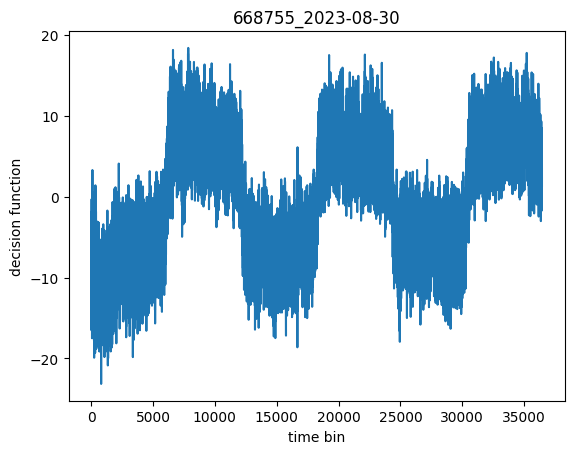

In [101]:
# window=sg.windows.gaussian(10,5)
window=np.ones(5)
fig,ax=plt.subplots(1,1)
temp_dec_func=dec_func[0]['block_ids'][1]['all']['average']#/np.nanstd(dec_func[0]['block_ids'][1]['all']['average'])
ax.plot(temp_dec_func)
# ax.plot(sg.convolve(temp_dec_func,window,mode='same')/np.sum(window))
ax.set_xlabel('time bin')
ax.set_ylabel('decision function')
ax.set_title(svc_results[0]['metadata'].session_id)

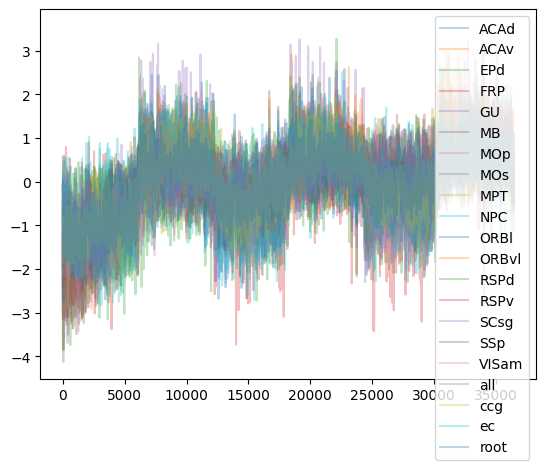

In [7]:
fig,ax=plt.subplots(1,1)
for aa in all_areas:
    
    temp_dec_func=dec_func[0]['block_ids'][1][aa]['average']/np.nanstd(dec_func[0]['block_ids'][1][aa]['average'])
    temp_dec_func=sg.convolve(temp_dec_func,np.ones(10)/10,mode='same')
    ax.plot(temp_dec_func,label=aa,alpha=0.3)

# ax.vlines(context_switch_index,ymin=-9,ymax=9)
ax.legend()

In [8]:
all_areas=np.unique(np.hstack(all_areas))
unit_numbers=np.arange(0,len(svc_results[0]['unit_numbers']))

# decoder_conf_context_switch[area][n_units]

decoder_conf_context_switch={}

# loop through areas
for aa in all_areas:
    decoder_conf_context_switch[aa]={}

    # loop through n units
    for n_units in unit_numbers:
        decoder_conf_context_switch[aa][n_units]=[]


for sel_session in range(0,len(svc_results)):
    session_id=svc_results[sel_session]['metadata'].session_id
    print(session_id)

    #load session table
    session=DynamicRoutingSession(session_id)

    bin_size=0.1
    timebins_table,bins=spike_utils.make_timebins_table(session.trials[:], bin_size)

668755_2023-08-30


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 513/513 [01:32<00:00,  5.54trial/s]


In [ ]:
# bin_size=0.1
# timebins_table,bins=spike_utils.make_timebins_table(session.trials[:], bin_size)

In [ ]:
timebins_table.columns

In [9]:
context_switch_index=timebins_table.query('is_context_switch').index.values
# context_switch_index

reward_after_context_switch=[]
reward_index=timebins_table.query('reward').index.values
for cc in context_switch_index:
    reward_after_context_switch.append(reward_index[np.where(reward_index>cc)[0][0]])

reward_after_context_switch=np.array(reward_after_context_switch)

In [ ]:
reward_after_context_switch

In [10]:
switch_aligned_decoding={}

# loop through areas
for aa in all_areas:
    switch_aligned_decoding[aa]={}

    # loop through n units
    for n_units in unit_numbers:
        switch_aligned_decoding[aa][n_units]=[]

bins_before=300
bins_after=900

p='block_ids'

for aa in all_areas:
    for n_units in unit_numbers:

        for rc in context_switch_index:
            
            if timebins_table['is_vis_context'].iloc[rc]:
                multiplier=-1
            elif timebins_table['is_aud_context'].iloc[rc]:
                multiplier=1

            temp_bin_decoding=(dec_func[0]['block_ids'][n_units][aa]['average'][rc-bins_before:rc+bins_after]
                            /np.nanstd(dec_func[0]['block_ids'][n_units][aa]['average'][rc-bins_before:rc+bins_after]))*multiplier
            
            switch_aligned_decoding[aa][n_units].append(temp_bin_decoding)

switch_aligned_decoding[aa][n_units]=np.vstack(switch_aligned_decoding[aa][n_units])


AttributeError: 'dict' object has no attribute 'T'

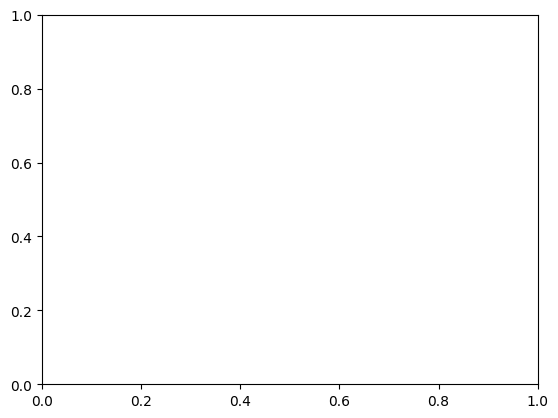

In [11]:
timebins=np.arange(-bins_before*bin_size,bins_after*bin_size,bin_size)
fig,ax=plt.subplots(1,1)
ax.plot(timebins,switch_aligned_decoding.T)
ax.plot(timebins,np.nanmean(switch_aligned_decoding,axis=0),color='k',linewidth=3)
ax.axvline(0,color='k')
ax.axhline(0,color='k')

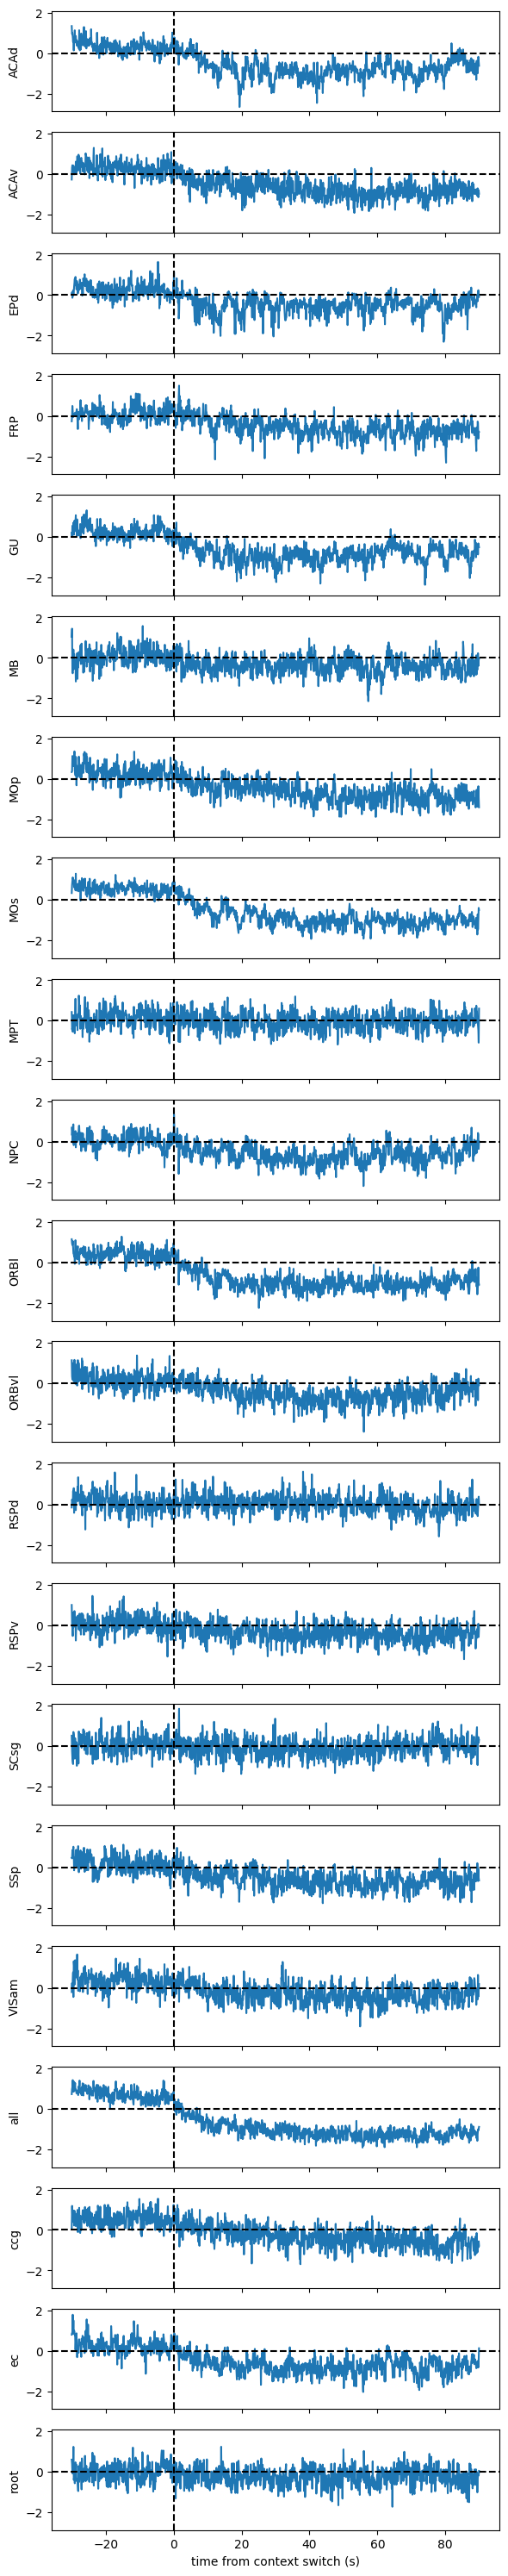

In [12]:
sel_n_units=0

timebins=np.arange(-bins_before*bin_size,bins_after*bin_size,bin_size)

fig,ax=plt.subplots(len(all_areas),1,figsize=(6,30),sharex=True,sharey=True)

for ia,aa in enumerate(all_areas):
    if ia<10:
        set_linestyle='-'
        set_marker='.'
    else:
        set_linestyle='--'
        set_marker='^'

    if sel_n_units in switch_aligned_decoding[aa].keys():
        ax[ia].plot(timebins,np.nanmean(switch_aligned_decoding[aa][n_units],axis=0),label=aa)

    ax[ia].set_ylabel(aa)
    ax[ia].axvline(0,color='k',linestyle='--')
    ax[ia].axhline(0,color='k',linestyle='--')
# ax.axvline(0,color='k',linestyle='--')
# ax.axhline(0,color='k',linestyle='--')
# ax.legend()
# ax.set_xlim([-20,40])
# # ax.set_ylim([-0.7,1.25])
ax[ia].set_xlabel('time from context switch (s)')
# ax.set_ylabel('prev <- normalized context confidence -> current')
# ax.set_title('n='+str(svc_results[0]['unit_numbers'][sel_n_units])+' units per area')
fig.tight_layout()

In [35]:
# ax[ia].set_xlabel('X')

Text(0.5, 4.444444444444452, 'X')

In [31]:
# switch_aligned_decoding[aa][n_units]
switch_aligned_decoding[aa]

{0: [array([ 1.67830441,  1.35121593,  1.29171144, ...,  0.53217988,
         -0.28419181, -0.21687578]),
  array([-0.60559866, -1.73373711, -0.94198602, ..., -2.13839467,
         -3.56116996, -2.53050574]),
  array([ 0.68010714, -0.10542013,  0.44780746, ..., -0.65866409,
         -0.41493763,  0.14042348]),
  array([ 1.00036483,  1.20153716,  1.36788895, ..., -1.3464618 ,
         -0.62723853, -0.556776  ]),
  array([ 0.86851098,  0.60338355,  0.49722193, ..., -1.62466023,
         -2.04301626, -1.15881822])],
 1: array([['ACAd'],
        ['ACAv'],
        ['CA1'],
        ['DP'],
        ['ILA'],
        ['LH'],
        ['MOp'],
        ['MOs'],
        ['RSPd'],
        ['all']], dtype='<U4')}

In [ ]:
timebins_table.loc[reward_after_context_switch]

In [ ]:
timebins_table.loc[15000]

(6000.0, 6200.0)

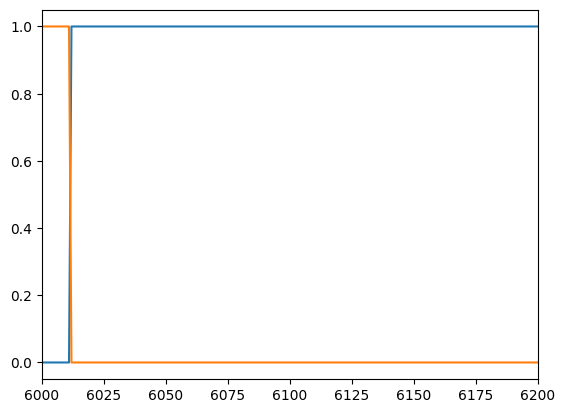

In [9]:
fig,ax=plt.subplots(1,1)
ax.plot(timebins_table['is_vis_context'])
ax.plot(timebins_table['is_aud_context'])
ax.set_xlim([6000,6200])

In [ ]:
# find the decoder confidence around context changes (aligned to stim, or aligned to reward)
